In [1]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

In [2]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [3]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import graphviz as gr
random.seed(10)

In [4]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

## 1.Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates.

## a.Experiments with no covariates in the DGP
       𝑦𝑖=𝜏∗𝑇𝑖+𝑒𝑖
       
We design experiments to investigate whether job training programs have an impact on individual wages. So in this case, t is the job traning program, y is the wage, and there are no other covariates.

## Simulate a DGP

In [5]:
tau = 2
corr = .5
conf=False
p = 10
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 495/495 [00:01<00:00, 424.83it/s]


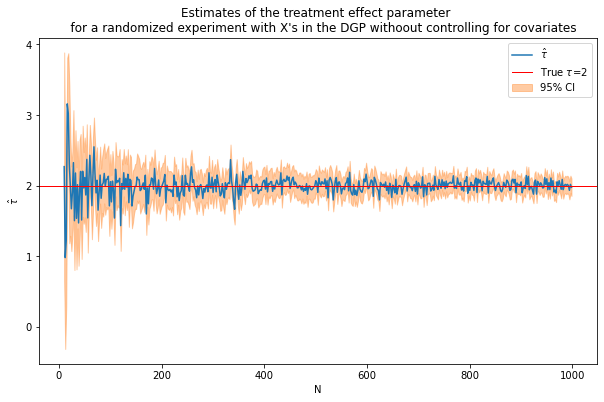

In [6]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment with X's in the DGP withoout controlling for covariates """
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)


## Illustrate your DGP with a DAG

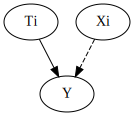

In [7]:
g = gr.Digraph()
g.edge("Ti","Y")
g.edge("Xi","Y",style="dashed")
g

## Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias, RMSE and size of your treatment effect estimate is.

In [8]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [9]:
tauhat,se_tauhat

(2.0092507092976266, 0.20276781657112977)

In [10]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])

In [11]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(2.0092507092976266, 0.20276781657112974)

In [12]:
N = 1000
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [13]:
tauhat,se_tauhat

(2.0458008825076908, 0.06322455305618176)

In [14]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])

In [15]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(2.045800882507691, 0.0632245530561818)

In [16]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:11<00:00, 179.73it/s]


In [17]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    

N=100: bias=0.0020900977066046684, RMSE=0.20541829133212172, size=0.0615
N=1000: bias=1.203413089392702e-05, RMSE=0.06384187231764632, size=0.051


## Give an example of a real-life situation that might be consistent with the DGP.

There are many factors affecting wages,such as age,race,education level,gender,job training program and work experience.However,if you do not control for any covariates,the average treatment effect would be biased.

## b.Experiments with covariates in the DGP
   𝑦𝑖=𝜏∗𝑇𝑖+𝛽′∗𝑥𝑖+𝑒𝑖
   
There may be other covariates that have an effect on wage in real life, such as race, education, gender, age, etc. In this experiment, we will add some covariates.

## Simulate a DGP

In [18]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_x,tauhats_x,sehats_x,lb_x,ub_x) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 495/495 [00:03<00:00, 148.80it/s]


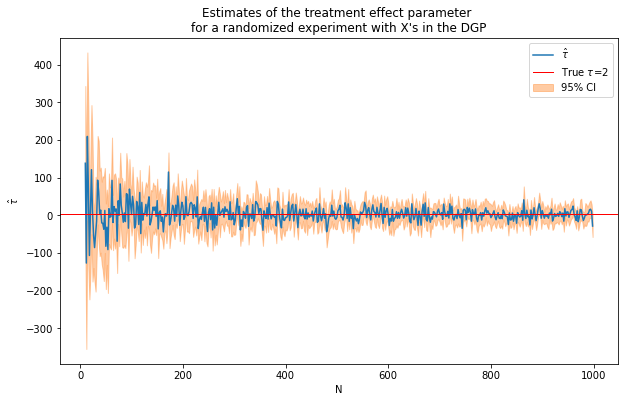

In [19]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP"""
fn_plot_with_ci(nvalues_x,tauhats_x,tau,lb_x,ub_x,caption)

In [20]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_x0,tauhats_x0,sehats_x0,lb_x0,ub_x0) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 495/495 [00:03<00:00, 144.83it/s]


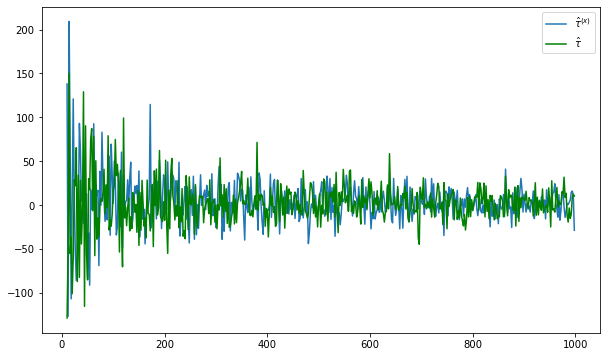

In [21]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x,tauhats_x,label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x,tauhats_x0,label = '$\hat{\\tau}$',color = 'green')
plt.legend()

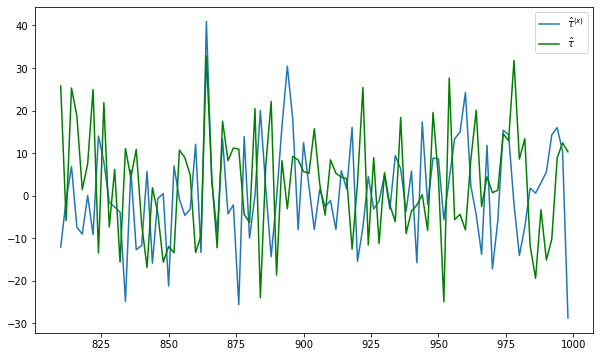

In [22]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x[400:],tauhats_x[400:],label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x[400:],tauhats_x0[400:],label = '$\hat{\\tau}$',color = 'green')
plt.legend()

There exits noise.

In [23]:
tau = 2
corr = .5
conf=False
p = 1000
p0 = 50 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_x,tauhats_x,sehats_x,lb_x,ub_x) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 495/495 [00:38<00:00, 12.80it/s]


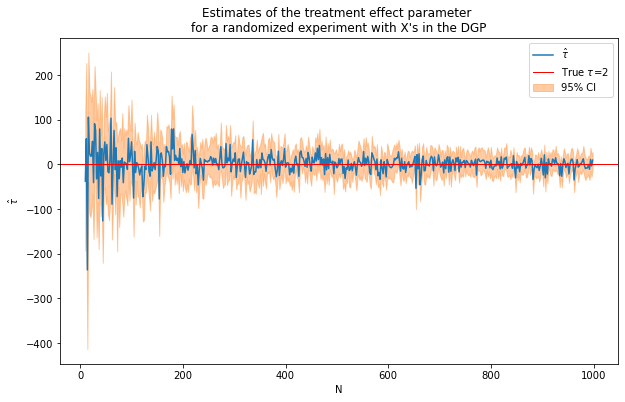

In [24]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP"""
fn_plot_with_ci(nvalues_x,tauhats_x,tau,lb_x,ub_x,caption)

In [25]:
tau = 2
corr = .5
conf=False
p = 1000
p0 = 50 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_x0,tauhats_x0,sehats_x0,lb_x0,ub_x0) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 495/495 [00:37<00:00, 13.24it/s]


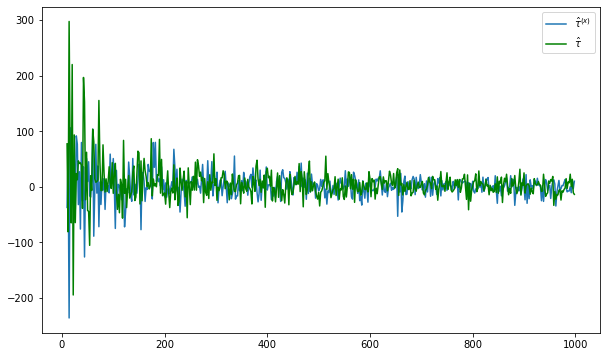

In [26]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x,tauhats_x,label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x,tauhats_x0,label = '$\hat{\\tau}$',color = 'green')
plt.legend()

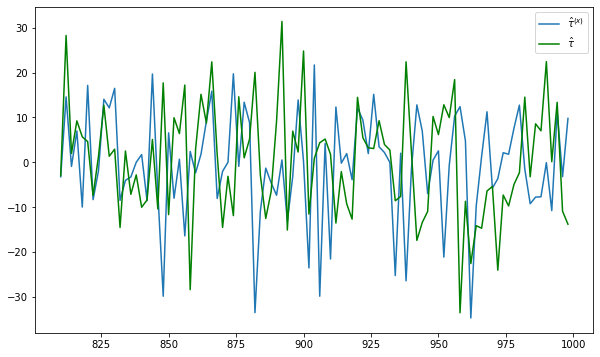

In [27]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x[400:],tauhats_x[400:],label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x[400:],tauhats_x0[400:],label = '$\hat{\\tau}$',color = 'green')
plt.legend()

In [28]:
# Use same DGP as
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 1
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|██████████| 450/450 [00:04<00:00, 91.71it/s] 


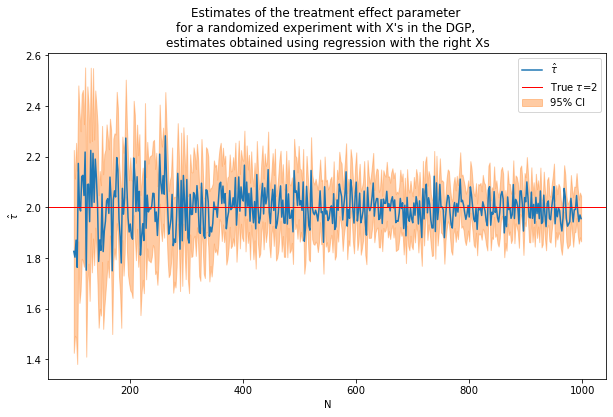

In [29]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP, 
estimates obtained using regression with the right Xs"""
fn_plot_with_ci(nvalues2,tauhats2,tau,lb2,ub2,caption)

In [30]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [31]:
tauhat,se_tauhat

(1.822943766388584, 0.20769767432232955)

In [32]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])

In [33]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(1.822943766388583, 0.20769767432232952)

In [34]:
N = 1000
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [35]:
tauhat,se_tauhat

(2.0122216651598577, 0.06210197084387075)

In [36]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])

In [37]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(2.0122216651598572, 0.06210197084387076)

## Illustrate your DGP with a DAG

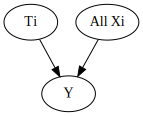

In [38]:
g = gr.Digraph()
g.edge("Ti","Y")
g.edge("All Xi","Y")
g

## Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias, RMSE and size of your treatment effect estimate is.

In [39]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:11<00:00, 168.78it/s]


In [40]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    

N=100: bias=-0.0037131753915670474, RMSE=0.20229810182428748, size=0.0565
N=1000: bias=0.0018344731640318184, RMSE=0.06246746122453446, size=0.052


## Give an example of a real-life situation that might be consistent with the DGP.

There may be other covariates that have an effect on wage in real life, such as race, education, gender, age, etc.We can add some covariates to DGP to make it more accurate.But in the case of influencing factors in wages, if we include too many trivial factors like hair color, the predictions will be noisy and inaccurate.

## 2.Simulate a DGP with a confounder (common cause)

## a. You fail to control for the confounder

## Simulate a DGP

In [41]:
tau = 2
corr = .5
# def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):在该函数里默认conf=true
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 1  #use the right covariates in regression
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|██████████| 450/450 [00:05<00:00, 86.38it/s] 


## Illustrate your DGP with a DAG

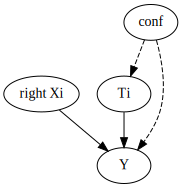

In [42]:
g = gr.Digraph()
g.edge("Ti","Y")
g.edge("right Xi","Y")
g.edge("conf","Y", style="dashed")
g.edge("conf","Ti",style="dashed")
g

## Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias, RMSE and size of your treatment effect estimate is.

In [43]:
estDict = {}
R = 2000
for N in [100,1000]: 
    tauhats = []
    sehats = []
    for r in tqdm(range(R)): 
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]  
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:11<00:00, 170.00it/s]


In [44]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.004353609666076806, RMSE=0.20237985669525305, size=0.0585
N=1000: bias=-0.0015461937594479047, RMSE=0.06463364804726948, size=0.0585


## Give an example of a real-life situation that might be consistent with the DGP.

In the case of influence factors of wages, Y could be wages; X could be education levels, race,gender,working experience, etc.,T could be participation in the job training program.

## b. You do control for the confounder

## Simulate a DGP

In [45]:
tau = 2
corr = .5
conf = False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 1  #use the right covariates in regression
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|██████████| 450/450 [00:05<00:00, 89.14it/s] 


## Illustrate your DGP with a DAG

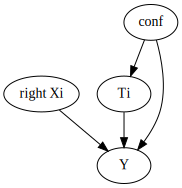

In [46]:
g = gr.Digraph()
g.edge("Ti","Y")
g.edge("right Xi","Y")
g.edge("conf","Y")
g.edge("conf","Ti")
g

## Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias, RMSE and size of your treatment effect estimate is

In [47]:
estDict = {}
R = 2000
for N in [100,1000]: 
    tauhats = []
    sehats = []
    for r in tqdm(range(R)): 
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]  
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:12<00:00, 161.70it/s]


In [48]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.002094687070266578, RMSE=0.20195434330364817, size=0.054
N=1000: bias=-0.000627889060422025, RMSE=0.0643062296894376, size=0.053


## Give an example of a real-life situation that might be consistent with the DGP.

In the case of influence factors of wages, Y could be wages; X could be education levels, race,gender,working experience, etc.,T could be participation in the job training program, confounder could be motivation. The most motivated individuals are more likely to participate in job training programs, while they also tend to be successful in their careers and earn higher wages due to their high motivation.In this case, we need to add control for confounders.We need to add motivation to our regression.¶

## 3. Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome) 


In [49]:
import statsmodels.api as sm
from numpy import sqrt 
import statsmodels.formula.api as smf

In [50]:
### Define a function to simulate data
def fn_generate_selection_data(tau1,N,beta1,lambda_x,conts = False):
    #Inputs
    # -tau: treatment effect parameter
    # -N: Number of observations (Sample size)
    # -conts: Indicating whether we control the mediators(selection bias variable)

    T = fn_randomize_treatment(N) # choose treated units
    err1 = np.random.normal(0,1,[N,1])
    X = beta1*T + err1
    err = np.random.normal(0,1,[N,1])

    Yab = tau1*T+lambda_x*X+err

    if conts == False:
        X = np.zeros([N,1])

    return Yab, T, X

### Define a function to estimate the treatment effect of random sample using OLS
def fn_estimate_params(Y,T,X):
    #Inputs
    # -Y: Outcome value of Dependent Variable
    # -T: Indicating the treatment group 0/1
    # -X: Value of Mediators(selection bias variable)

    covar = np.hstack([T,X])
    idx = np.argwhere(np.all(covar[..., :] == 0, axis=0))
    covars = np.delete(covar, idx, axis=1)

    mod = sm.OLS(Y,covars)
    res = mod.fit()
    tauhat = res.params[0]
    se_tauhat = res.HC1_se[0]

    return tauhat,se_tauhat

### Define a function to do the monte carlo simulation
def run_mc_simulation(n_rep,tau1,N,beta1,lambda_x,conts = False):
    #Inputs
    # -n_rep: Number of replication time for monte carlo simulation
    # -tau: treatment effect parameter
    # -N: Number of observations (Sample size)
    # -conts: Indicating whether we control the mediators(selection bias variable)

    estDict = {}
    for n in N:
        tauhats = []
        sehats = []
        for rep in tqdm(range(n_rep)):
            Y,T,X = fn_generate_selection_data(tau1,n,beta1,lambda_x,conts)
            tauhat,sehat = fn_estimate_params(Y,T,X)
            tauhats = tauhats + [tauhat]
            sehats = sehats + [sehat]
        estDict[n] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
        }

    return estDict

### Define a function to summarize the results of monte carlo simulation
def summarize_mc_simulation(tau1,lambda_x,beta1,n_rep,N,estDict):
    tau0 = (tau1+lambda_x*beta1)*np.ones([n_rep,1])
    for N, results in estDict.items():
        (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                             results['sehat'])

        print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

## Simulate a DGP

In [51]:
np.random.seed(73)
n = 1000
# generate treatment
T = np.random.binomial(1, 0.5, n)
# generate outcome
Y = np.random.normal(1 + 1*T, 5).astype(int)
# generate covariate
X = np.random.normal(10+np.mean(T)*np.mean(Y),5,n)

data3 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data3.to_csv("data3.csv", index=False)

## Illustrate DGP with a DAG

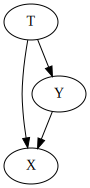

In [52]:
g = gr.Digraph()
g.edge("T", "X")
g.edge("T", "Y")
g.edge("Y", "X")
g

In [53]:
print(data3)

     T          X  Y
0    1  19.003576  0
1    1   7.114353 -5
2    1  12.977571  3
3    1   1.666997 -4
4    0  13.139657  3
..  ..        ... ..
995  0   9.399817 -7
996  1  10.033714  7
997  1  17.242560 -5
998  0  16.512007 -3
999  1   8.277151  3

[1000 rows x 3 columns]


## Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias, RMSE and size of your treatment effect estimate is

## a. You control for the variable in between the path from cause to effect

In [54]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(1 + 1*T, 5).astype(int)
        X = np.random.normal(10+np.mean(T)*np.mean(Y),5,n)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
        
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            a_hat,b_hat,c_hat = self.estimate_ols_params(Y,T,X)
            y_hat = a_hat + b_hat * T + c_hat * X
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [55]:
# N=100
mcSim_100 = MC_Simulator_a(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

C:\Users\glori\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,N=100,N=1000
bias,0.925866,0.922669
RMSE,4.555814,4.630021
treatment effect,0.926544,0.922632


## b. You do not control for the variable in between the path from cause to effect

In [56]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(1 + 1*T, 5).astype(int)
        X = np.random.normal(10+np.mean(T)*np.mean(Y),5,n)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            a_hat,b_hat = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [57]:
# N=100
mcSim_100 = MC_Simulator_b(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_b(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,0.927002,0.922572
RMSE,4.577431,4.631471
treatment effect,0.927002,0.922572


## Give an example of a real-life situation that might be consistent with the DGP.

Real life example: We want to find out if a job training program can have an effect on wages. In this case, the variable job training program is our instrumental variable. We can construct our model as:

$y_i = \tau*T_i+e_i$

But there are other variables will influence the instrumental variable as well as dependent variable. It is also necessary to take them into consideration. In this case, we can construct our formula as:  𝑌𝑖=𝜏′∗𝑇𝑖+𝑎∗𝑋𝑖+𝑒𝑖

The relationship between T_i and x_i can be written as:  𝑋𝑖=𝛽∗𝑇𝑖+𝑒𝑖

The relationship between tau'i and tau can be written as:  𝜏=𝜏′+𝑎∗𝛽
